# 4. Event Selection - Preparing Input Data for the Neural Network

In the last notebook the exemplary neural network from notebooks 1. and 2. was implemented using Keras making our lives significantly easier by outsourcing the solutions of difficult code, like forward and backward propagation, to Keras functions, ultimately simplifying the code and letting us concentrate on the physics problem at hand.

In this notebook we already want to dive deeper into the real physics at the LHC, CMS specifically, and preprocess the data for the neural network. This primarily entails the selection of the relevant events from the whole data by imposing cuts on physical quantities and event characteristics.

## Di - Higgs

The goal of this notebook series is to make a neural network that is capable of identifying Di-Higgs events. Di-Higgs events are events where a Higgs boson splits into two Higgs bosons via the 3-point self interaction. From the Higgs theory it is evident that this process is very rare and incredibly difficult to come by and identify. The primary Higgs can be produced in various ways, the most prevalent one being gluon-gluon-fusion accounting for about 87% of the  production. The two Higgs in the final state then continue to decay in different ways. One of the easiest and most efficient ways to identify a Di-Higgs event is to look for a bb + l signiture, where the bb jets come from one Higgs and the lepton originates from the other. For the signiture only muons are looked at (in this notebook at least), since it is easier to identify muons than electrons.

This process of course has it's fair share of background like the production of top quarks, production of W bosons associated with jets and many others due to various QCD interactions.

In this notebook real experimental data will not be used, instead, Monte Carlo simulated data for the separate signal and background processes will be used.

## Data opening and preparation

In [1]:
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import uproot
import hist
import mplhep
import vector
import os

In [2]:
# locate files
files = os.listdir('/nfs/dust/cms/user/matsch/for_Artak/WJetsToLNu/')
print(files)

['0B37487E-FC2E-D64C-89C1-F15ACD3F1904.root', '480ECDB4-0B6F-1442-B828-2D2F3A9DFD16.root', 'C0F742D7-C281-1E47-948C-40CDECBF977F.root']


Once the individual data files are located they are opened using *uproot*. Uproot is a python package that is capable of opening and manipulating *ROOT* format files. These are files structured in a similar way to UNIX file directories where objects can be stored in an arbitrary substructure in a machine independent fashion.

In [3]:
# register awkward to be able to use 4-vector behaviour 
vector.register_awkward()

# specify file paths
p_signal = '/nfs/dust/cms/user/matsch/for_Artak/GluGluToHHTobbVV/C6092B8E-34AB-324C-97BC-2FE673889E32.root'
p_bgr_tt = '/nfs/dust/cms/user/matsch/for_Artak/TTToSemiLeptonic/0520A050-AF68-EF43-AA5B-5AA77C74ED73.root'
p_bgr_st = '/nfs/dust/cms/user/matsch/for_Artak/ST_tW_top_5f_inclusive/5FEDA4F4-5EAA-9346-A62B-7488AE90CB0C.root'
p_bgr_Wj_1 = '/nfs/dust/cms/user/matsch/for_Artak/WJetsToLNu/C0F742D7-C281-1E47-948C-40CDECBF977F.root'
p_bgr_Wj_2 = '/nfs/dust/cms/user/matsch/for_Artak/WJetsToLNu/0B37487E-FC2E-D64C-89C1-F15ACD3F1904.root'
p_bgr_Wj_3 = '/nfs/dust/cms/user/matsch/for_Artak/WJetsToLNu/480ECDB4-0B6F-1442-B828-2D2F3A9DFD16.root'

# open files using uproot
# when opening a file, different types of data are written in a dictionary
signal = uproot.open(p_signal)
bgr_tt = uproot.open(p_bgr_tt)
bgr_st = uproot.open(p_bgr_st)
bgr_Wj_1 = uproot.open(p_bgr_Wj_1)
bgr_Wj_2 = uproot.open(p_bgr_Wj_2)
bgr_Wj_3 = uproot.open(p_bgr_Wj_3)

# make a list of the files so it's easier to iterate over the files and compactify the code
files_list = [signal, bgr_tt, bgr_st, bgr_Wj_1, bgr_Wj_2, bgr_Wj_3]

# read out trees
tree_list = [None for i in range(len(files_list))]

# particular data categories can be accessed with "key" "value" method by using sqare brackets
for count, file in enumerate(files_list):
    tree_list[count] = file["Events"]
    
print(tree_list)

[<TTree 'Events' (1628 branches) at 0x2abcc22a0e20>, <TTree 'Events' (1628 branches) at 0x2abcc22a0d90>, <TTree 'Events' (1628 branches) at 0x2abcc22a0f70>, <TTree 'Events' (1628 branches) at 0x2abcc22a0d30>, <TTree 'Events' (1628 branches) at 0x2abcc22a0ee0>, <TTree 'Events' (1628 branches) at 0x2abe351ca020>]


## Directly accessing fields via filters

Following the opening of the files, the necessary fields for the selection of events have to be specified and accessed via filters. This is done using a python package called *awkward*. It's great for nested variable-sized data and performs operations very quickly. The events from the different files are converted into awkward arrays all the while only the specified fields are selected. This is done such that muons and jets, the signature we are actively looking for, are stored separately in a list for all the files.

The fields that are relevant to this little analysis are:
* $p_T$ [GeV]
* $\eta$
* $\phi$ [rad]
* mass [GeV]
* charge

For jets there's additionally a field called "btagDeepB" which can be understood as the probability of a certain jet to be identified as a b-jet.

In [4]:
# necessary fields to be extracted
fields = ["pt", "eta", "phi", "mass", "charge", "btagDeepB"]

# only muons and jets are selected since they make up the desired signiture
muons_list = [None for i in range(len(tree_list))]
jets_list = [None for i in range(len(tree_list))]

# for each file the specified fields are selected for muons and jets only
for count, tree in enumerate(tree_list):

    muons_list[count] = tree.arrays(filter_name = ["Muon_" + f for f in fields])
    jets_list[count] = tree.arrays(filter_name = ["Jet_" + f for f in fields])

# concatenate all the same Wj events into a single list entry as if it originated from a single file
muons_list[-3] = ak.concatenate([muons_list[-3], muons_list[-2], muons_list[-1]], axis = 0)
del muons_list[-1]
del muons_list[-2]

jets_list[-3] = ak.concatenate([jets_list[-3], jets_list[-2], jets_list[-1]], axis = 0)
del jets_list[-1]
del jets_list[-2]

The goal is to combine all "particle arrays" to a single "events array" where in the subcategories the attributes are no more referenced as "{Object}\_{field}" but simply as the "{field}" .This is done using the function `replace`. Additionally, the argument `with_name = 'Momentum4D'` is given, which identifies the elements of the arrays as physical 4-vectors which in turn allows them to be used in physically relevant operations like the calculation of the invariant mass of the objects. With `zip` the new fields are combined in a new array. And finally, the two object arrays, muons and jets are zipped to construct the event array. The different subcategories can still be accessed by using the particle type and physical quantities as attributes.

In [5]:
# switch naming of fields from "{Object}_{field}" to "{field}"
events_list = [None for i in range(len(muons_list))]

for i in range(len(muons_list)):
    
    muons_list[i] = ak.zip({key.replace("Muon_",""):muons_list[i][key] for key in muons_list[i].fields}, with_name = "Momentum4D")
    jets_list[i] = ak.zip({key.replace("Jet_",""):jets_list[i][key] for key in jets_list[i].fields}, with_name = "Momentum4D")

    # combine fields into a single awkward "events array" via ak.zip
    events_list[i] = ak.zip({"Muon": muons_list[i], "Jet": jets_list[i]}, depth_limit=1)
# the lists corresponding to the arrays contain multiple numbers

print("Event fields:      ", events_list[0].fields)
print("")
print("Muon fields:       ", events_list[0].Muon.fields)
print("Muon object class: ", type(events_list[0].Muon))
print("")
print("Jet fields:        ", events_list[0].Jet.fields)
print("Jet object class:  ", type(events_list[0].Jet))

Event fields:       ['Muon', 'Jet']

Muon fields:        ['eta', 'mass', 'phi', 'pt', 'charge']
Muon object class:  <class 'vector._backends.awkward_.MomentumArray4D'>

Jet fields:         ['btagDeepB', 'eta', 'mass', 'phi', 'pt']
Jet object class:   <class 'vector._backends.awkward_.MomentumArray4D'>


## Event selection

We hope to examine the final states of the events and search for a signature that might be reminiscent of the decay of two Higgs bosons which might indicate a Di-Higgs event. The selection is performed by making various cuts on the data. Namely:

Muons:
* exactly one muon
* minimum $p_T$ of 25 GeV
* no constraint on $\eta$

Jets:
* at least 4 jets
* two of which must be b-jets
* minimum $p_T$ of 25 GeV
* no constraint on $\eta$

The btagDeepB is not a binary response and can attain the continuous range of values betweeen 0 and 1. Thus "determining" if a jet is identified as a b-jet depends on the *workingpoint* with which a b-jet is "defined".

The cuts on $p_T$ (and $\eta$) are cuts on objects whereas cuts on the number of objects are cuts on the events. They are performed in a particular order: object cuts first, event cuts second. This is to guarantee that only those events are selected which feature the desired signature.

In [6]:
# th most common workingpoints for b-jet identifikation
btag_loose = 0.1208
btag_medium = 0.4168
btag_tight = 0.7665

The cuts are performed by applying masks on the arrays, selecting only those objects / events which satisfy the signature. Separate functions have been written to return the object and event masks, with unique event masks for leptons and jets respectively, as different numbers of objects are required for the two. Exclusively for the jets, another function has been defined that solely returns the b-tagging mask. Both the masks as well as the cut requirements on the various physical quantities are exemplarily hard-coded in this notebook, but you are very much welcome to make improvements to it!

The way it is implemented down below, applying the mask overwrites the event data such that the remaining data is the one of interest. Notice how the event masks are defined and applied immediately after i.e before defining the following event masks. This is due to the fact that masks have to be defined for the exact arrays they are supposed to act on. If an event mask is applied to an array which the mask was not defined on, an error will be raised. This is not an issue for object masks, since the arrays stay the "same" in terms of still featuring the event (eventhough certain objects might have been cut).

In [7]:
# create a mask that cuts objects
def object_mask(obj, eta, pt):
    return (np.abs(obj.eta) < eta) & (obj.pt > pt)

# create mask that cuts events by requiring a certain number of lepton objects
def number_lep_mask(event, n):
    return (ak.num(event) == n)

# create mask that cuts events by requiring a certain number of jet objects
def number_jet_mask(event, n):
    return (ak.num(event) >= n)

# create mask that cuts events by requiring a certain number of b-jet objects
def number_btag_mask(event, b):
    return (ak.num(event[event.btagDeepB > btag_tight]) == b)


# masking function
def mask_events(event_data):   

    # muon properties
    m_eta = 10
    m_pt = 25
    m_n = 1
    
    # jet properties
    j_eta = 10
    j_pt = 25
    j_n = 4
    j_btag = 2
    
    # mask for object based cuts on the full event data
    m_mask_obj = object_mask(event_data['Muon'], m_eta, m_pt)
    j_mask_obj = object_mask(event_data['Jet'], j_eta, j_pt)
    
    # apply object based cuts on full event data and overwrite original data
    event_data['Muon'] = event_data['Muon'][m_mask_obj]
    event_data['Jet'] = event_data['Jet'][j_mask_obj]
            
    # mask for and apply event based cut on object-masked data    
    m_mask_n = number_lep_mask(event_data['Muon'], m_n)
    event_data = event_data[m_mask_n]
    
    j_mask_n = number_jet_mask(event_data['Jet'], j_n)
    event_data = event_data[j_mask_n]
    
    j_mask_b = number_btag_mask(event_data['Jet'], j_btag)
    event_data = event_data[j_mask_b]

    # number of events after performing cuts
    events_final = ak.num(event_data)

    return event_data #events_final, len(events_final)
    

In [8]:
# finally apply selection on data
selection_list = [None for i in range(len(muons_list))]

for count, events in enumerate(events_list):
    selection_list[count] = mask_events(events)

## Plot selection in histograms

The "physics" of a process is given by the cross section associated with it. Statements on the cross section can be made by measuring the integrated luminosity, which is solely given by the experiment, and detecting the number of events:

### $(1) \,\,\, N = L_{int} \cdot \sigma$

We now wish to plot the selection of the signal data and background data in the same plot to compare the number of events in a histogram. For the histogram to make physical sense, the luminosities of the processes have to be the same such that the number of events for signal and background processes are given by the proportional differences between the cross sections. The cross sections for the signal and background processes are all very known values from theoretical calculations and experimental results. The situation for the luminosities, though, is very different. Since the data that is being used for this notebook is from Monte Carlo simulations the "effective luminosities" with which the events are generated, can be arbitrarily high. Naturally, for comparable file sizes, the effective luminosities are very different for the processes that are being considered here. The different contributions to the histograms thus have to be weighted for the number of events of the processes to be in correct proportions.

First, the effective luminosities are calculated using formula $(1)$. It is important to note, that for $N$ the number of all events in the data has to be used not only the selected events. This is of course because all events in the files are simulated as e.g. Di-Higgs signals. The selection only contains the Di-Higgs events which match the signature we are looking for. The same is true for the background. The weights are calculated as the fractions of the effective luminosities and a "real" luminosity which is supposed to immitate a certain experiment. Since it only specifies the scale for the number of events and has no influence on the relative differences it is exemplarily set to 1.

In [9]:
# cross sections and weights: N = L * sigma

# cross sections in pb
sig_HH = 3.4491e-3
sig_tt = 364.33
sig_st = 35.85
sig_Wj = 3130

# number of generated events prior to selection
N_HH = len(ak.num(events_list[0]))
N_tt = len(ak.num(events_list[1]))
N_st = len(ak.num(events_list[2]))
N_Wj = len(ak.num(events_list[3]))

# "real" luminosity in pb (this value is not actually correct, it's just to get the point across)
L = 1

# Monte Carlo luminosities
L_HH = N_HH / sig_HH
L_tt = N_tt / sig_tt
L_st = N_st / sig_st
L_Wj = N_Wj / sig_Wj

# weights relative to signal luminosity
w_HH = L / L_HH
w_tt = L / L_tt
w_st = L / L_st
w_Wj = L / L_Wj

weights = [w_HH, w_tt, w_st, w_Wj]

print(weights)

[1.4027574426549536e-08, 0.0002815533230293663, 5.584112149532711e-05, 0.008292137570006304]


Before the histograms can be plottet they have to be constructed first. For this another package called *hist* is used. It's the prevailing method of making histograms in the context of high energy physics. Histograms are made for muons and jets separately, each with the subcategories of signal and the various backgrounds that are being considered. New histograms are made by calling `hist.Hist.new`. The physical quantities in respect to which the histogram can be plotted are added by simply specifying the axis type (type of binning) and the name. The *string category* axis makes a histogram based on the string attributes specified. The *regular* axis makes a histogram with a set number of equally sized bins ranging from a starting value to an ending value. The *variable* axis makes a histogram with manually set bins which do not have to have the same size. There are also other axis types but they won't be used here. All of these axes can be embedded into a single "multidimensional" hist object.

The histograms also have to be filled with data. This is done with the `fill` function where it is important that the axis names correspond to the variables that are being filled and also that the data to be filled is flattened. Otherwise an error is raised.

In [10]:
# object list
objects = [["Muon", ["signal", "bgr_tt", "bgr_st", "bgr_Wj"]], ["Jet", ["signal", "bgr_tt", "bgr_st", "bgr_Wj"]]]

object_hist_dict = {}

for i in objects:

    # construct histogram for muons and jets displaying the distribution in pt, eta and phi
    object_hist_dict[i[0]] = (
        hist.Hist.new
        .StrCat([i[1][0], i[1][3], i[1][2], i[1][1]], name = "object_type", label = "object") # histrogramm with 4 separate categories
        .Reg(20, 30, 100, name = "pt", label = f"{i[0]} " + "$p_{T}$ [GeV]") # histogram with regular sized bins (20 bins, starting pt 30 ending pt 100)
        .Var(np.linspace(-2.5, 2.5, 20), name = "eta", label = f"{i[0]} " + "$\eta$") # histogram with variable sized bins (specified bins [])
        .Reg(20, -np.pi, np.pi, name = "phi", label = f"{i[0]} " + "$\\phi$")
        .Double() # what is this though?
    ) 

    for count, sub_cat in enumerate(i[1]):
    
        # Pass keyword arguments to fill, all arrays must be flat numpy arrays
        # User is responsible for ensuring all arrays have same jagged structure!

        # histogram fill for electrons
        object_hist_dict[i[0]].fill(
            object_type = sub_cat,
            pt = ak.flatten(selection_list[count][i[0]].pt),
            eta = ak.flatten(selection_list[count][i[0]].eta),
            phi = ak.flatten(selection_list[count][i[0]].phi),
            weight = weights[count]
        )

In [84]:
# construct sub histograms to be plotted 
selection_hist = [[object_hist_dict['Muon'][0, :, ::sum, ::sum], object_hist_dict['Muon'][1:, :, ::sum, ::sum]], # signal, background vs pt
                  [object_hist_dict['Muon'][0, ::sum, :, ::sum], object_hist_dict['Muon'][1:, ::sum, :, ::sum]], # signal, background vs eta
                  [object_hist_dict['Muon'][0, ::sum, ::sum, :], object_hist_dict['Muon'][1:, ::sum, ::sum, :]], # signal, background vs phi
                  [object_hist_dict['Jet'][0, :, ::sum, ::sum], object_hist_dict['Jet'][1:, :, ::sum, ::sum]],   # signal, background vs pt
                  [object_hist_dict['Jet'][0, ::sum, :, ::sum], object_hist_dict['Jet'][1:, ::sum, :, ::sum]],   # signal, background vs eta
                  [object_hist_dict['Jet'][0, ::sum, ::sum, :], object_hist_dict['Jet'][1:, ::sum, ::sum, :]]]   # signal, background vs phi

From the two histograms that have been made and filled for the muons and jets the number of events in dependance of $p_T$, $\eta$ and $\phi$ can be plotted.

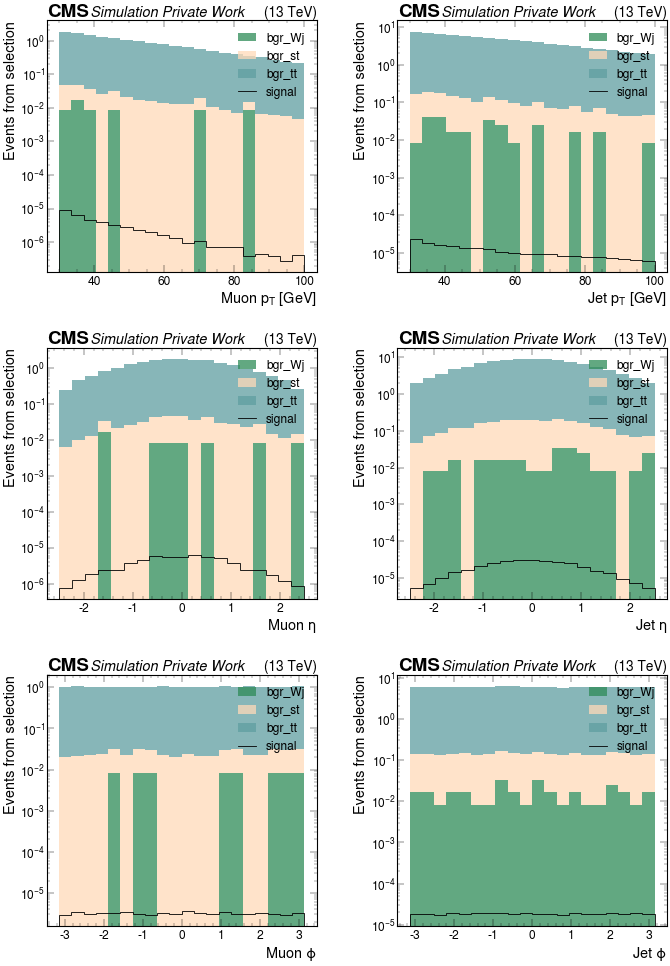

In [85]:
# cms style
plt.style.use(mplhep.style.CMS)

fig = plt.figure(figsize = (20, 20*3/2), facecolor = 'white', dpi = 40)

fig.subplots_adjust(wspace=0.3, hspace=0.3)

# a splash of color
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["seagreen", "peachpuff", "cadetblue"])
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["thistle", "mediumorchid", "indigo"])
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["limegreen", "yellow", "red"])

# opacity of the plots
a = 0.75

# assignment of axes
ax1 = fig.add_subplot(3, 2, 1)
ax4 = fig.add_subplot(3, 2, 2)
ax2 = fig.add_subplot(3, 2, 3)

ax5 = fig.add_subplot(3, 2, 4)
ax3 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

axes = {0: ax1, 1: ax2, 2: ax3, 3: ax4, 4: ax5, 5: ax6}

for count, sub_hist in enumerate(selection_hist):
    
    # plot of background sub histogram
    sub_hist[1].plot1d(
        ax = axes[count],
        overlay = "object_type",
        histtype = "fill",
        stack = True,
        alpha = a,
        edgecolor = (0, 0, 0, 0.3),
        # label = "muons"
    )
    
    # plot of signal sub histogram
    sub_hist[0].plot1d(
        ax = axes[count],
        overlay = "object_type",
        histtype = "step",
        stack = False,
        alpha = 1,
        edgecolor = (0, 0, 0, 0),
        label = "signal"
    )

    axes[count].semilogy()
    axes[count].set_ylabel("Events from selection")
    mplhep.cms.label(ax = axes[count], label="Private Work")
    axes[count].legend()

plt.show()

The first time you run the cell above after restarting the kernel, the title, axes and legend are shown super tiny. Just run the cell again and everything should be fine.

# BACKUP CELLS